# Segmentação de imagens médicas - Notebook responsavel pelo teste e validação

# Importação das bibliotecas

In [ ]:
import os
import numpy as np
import cv2
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow
from tensorflow.keras.optimizers.legacy import Adam
import random
from glob import glob
from imageio import mimread
from google.colab.patches import cv2_imshow
import tensorflow_datasets as tfds
tensorflow.__version__

'2.11.0'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Carregando o modelo de rede neural já treinado

In [ ]:
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model

In [ ]:
from keras import backend as K

""" IoU """
def iou(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

""" Dice Coefficient """
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

""" Dice Coefficient Loss """
def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [ ]:
with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_coef_loss': dice_coef_loss}):
  modelo_teste = load_model('/content/gdrive/MyDrive/Segmentacao/modelo/modelo_drive_47.h5')

# Teste da rede neural

In [ ]:
def ler_img(caminho):
  img = cv2.imread(caminho, cv2.IMREAD_COLOR)
  img_original = img.copy()
  img = img / 255.0
  img = img.astype(np.float32)
  return img, img_original

In [ ]:
def ler_mascara(caminho):
    img = cv2.imread(caminho, cv2.IMREAD_GRAYSCALE) 
    img_original = img
    img = img/255.0
    img = img.astype(np.int32)
    return img, img_original 

In [ ]:
def segmenta_img(img, modelo_teste):
  predicao = modelo_teste.predict(np.expand_dims(img, axis=0))[0]
  predicao = predicao > 0.5
  predicao = predicao.astype(np.int32)
  predicao = np.squeeze(predicao, axis=-1)
  return predicao

In [ ]:
def carregar_dataset(caminho):
  X_train = sorted(glob(os.path.join(caminho, "train", "principal", "*.png")))
  y_train = sorted(glob(os.path.join(caminho, "train", "mask", "*.jpg")))

  X_test = sorted(glob(os.path.join(caminho, "test", "principal", "*.png")))
  y_test = sorted(glob(os.path.join(caminho, "test", "mask", "*.jpg")))

  return (X_train, y_train), (X_test, y_test)

In [ ]:
caminho = '/content/gdrive/MyDrive/Segmentacao/medical-images'

In [ ]:
(X_train, y_train), (X_test, y_test) = carregar_dataset(caminho)

In [ ]:
lista_teste = np.random.choice(len(X_test), 5)

In [ ]:
def segmenta_img(img, modelo_teste):
  predicao = modelo_teste.predict(np.expand_dims(img, axis=0))[0]
  predicao = predicao > 0.5
  predicao = predicao.astype(np.int32)
  predicao = np.squeeze(predicao, axis=-1)
  return predicao

In [ ]:
lista_teste = np.random.choice(len(X_test), 5)

1/1 [==============================] - 8s 8s/step


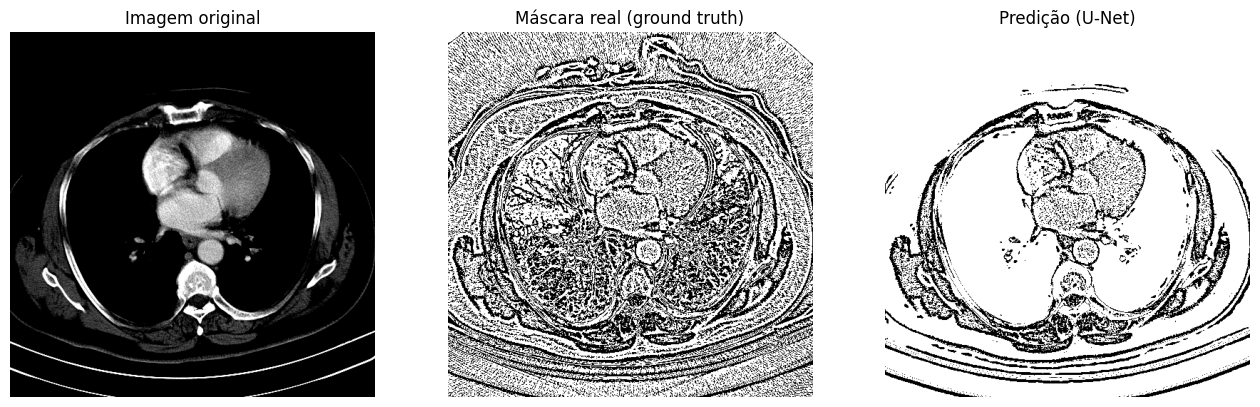

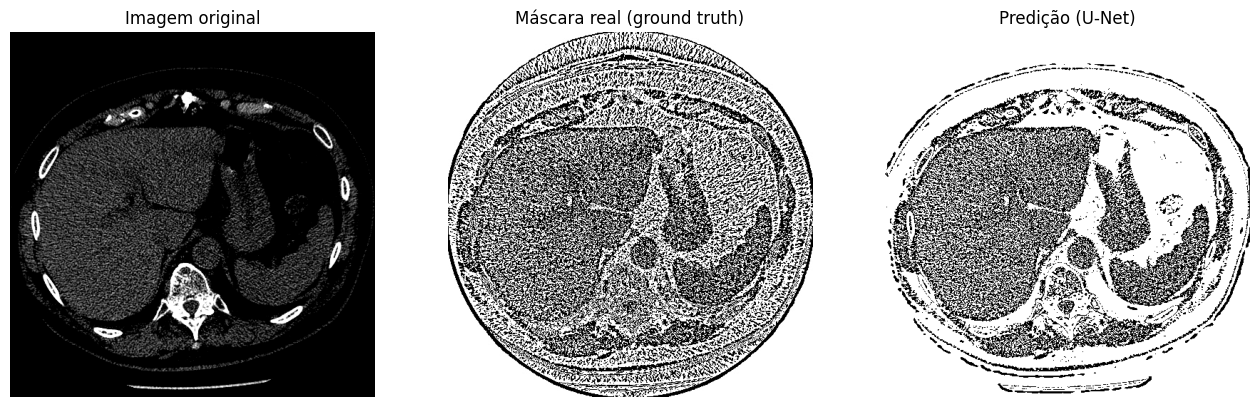

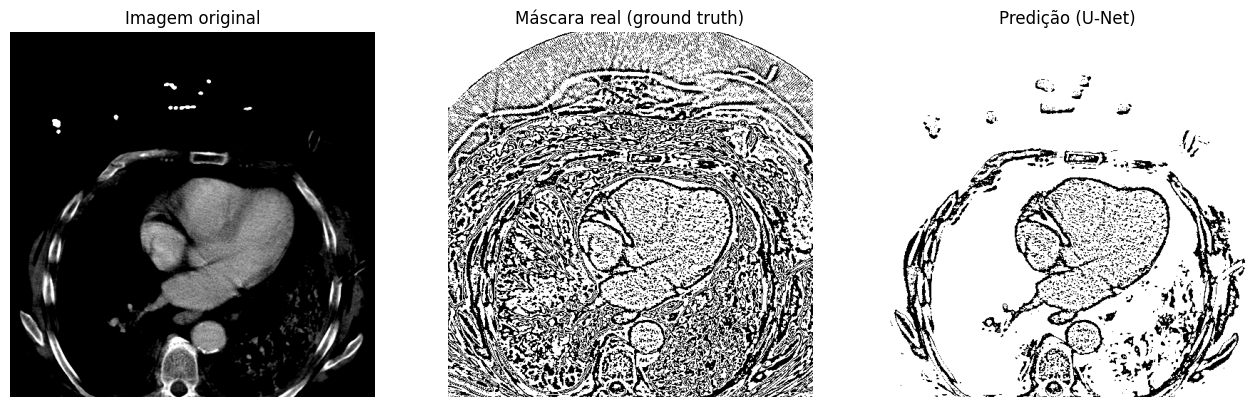

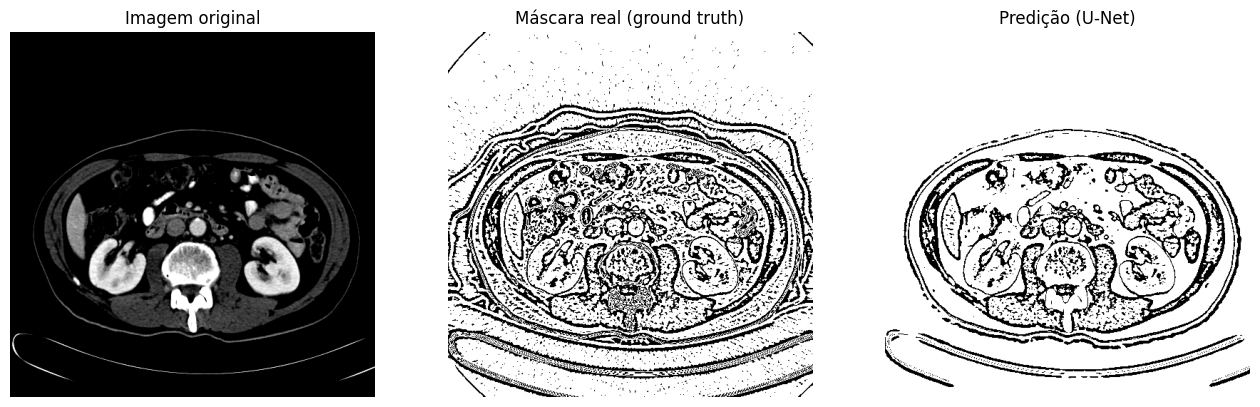

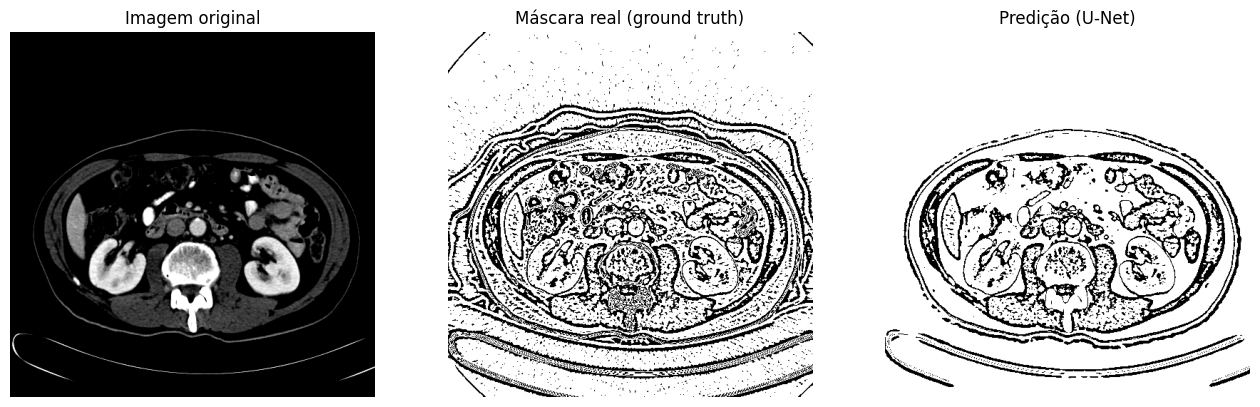

In [ ]:
for id_img in lista_teste:
  img, img_original = ler_img(X_test[id_img])
  mask, mask_original = ler_mascara(y_test[id_img])
  predicao = segmenta_img(img, modelo_teste)

  fig = plt.figure(figsize=(16, 8))
  fig.add_subplot(1,3,1)  
  plt.imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
  plt.axis("off")
  plt.title("Imagem original")

  plt.subplot(1,3,2)
  plt.imshow(mask_original, cmap="gray")
  plt.axis("off")
  plt.title("Máscara real (ground truth)") 
  
  plt.subplot(1,3,3)  
  plt.imshow(predicao, cmap="gray")
  plt.axis("off")
  plt.title("Predição (U-Net)")   

# Avaliação

In [ ]:
from sklearn.metrics import accuracy_score
from tensorflow.keras.metrics import MeanIoU

In [ ]:
id_img = 0
img, img_original = ler_img(X_test[id_img])
mask, mask_original = ler_mascara(y_test[id_img])
predicao = segmenta_img(img, modelo_teste)

1/1 [==============================] - 7s 7s/step


In [ ]:
mask.shape, predicao.shape

((512, 512), (512, 512))

In [ ]:
pred_ = predicao.flatten()
mask_ = mask.flatten()
pred_.shape, mask_.shape

((262144,), (262144,))

In [ ]:
# IoU
iou_resultado = MeanIoU(num_classes = 2)
iou_resultado.update_state(mask, predicao)
valor_iou = iou_resultado.result().numpy()

In [ ]:
mask_, np.unique(mask_, return_counts=True)

(array([1, 1, 1, ..., 1, 1, 1], dtype=int32),
 (array([0, 1], dtype=int32), array([158045, 104099])))

In [ ]:
valor_acc = accuracy_score(mask_, pred_)

IoU:  0.27537212
Accuracy:  0.46810150146484375


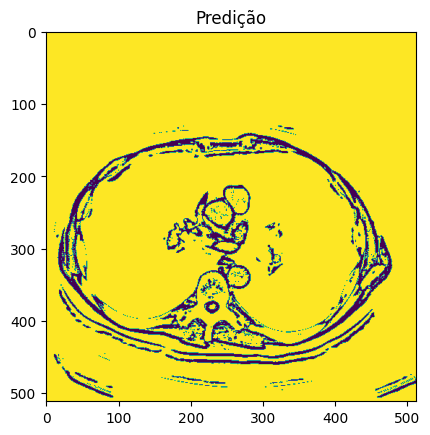

In [ ]:
plt.imshow(predicao)
plt.title('Predição')
print('IoU: ', valor_iou)
print('Accuracy: ', valor_acc)

In [ ]:
lista_scores = []
for x, y in tqdm(zip(X_test, y_test), total=len(X_test)):
    nome = x.split("/")[-1].split(".")[0]

    img, img_original = ler_img(x)
    mask, mask_original = ler_mascara(y)
    predicao = segmenta_img(img, modelo_teste) 
    
    mask_ = mask.flatten()
    pred_ = predicao.flatten()

    IoU_resultado = MeanIoU(num_classes=2)  
    IoU_resultado.update_state(mask, predicao) 
    valor_iou = IoU_resultado.result().numpy() 
    
    valor_acc = accuracy_score(mask_, pred_)
    
    lista_scores.append([nome, valor_iou, valor_acc])

medias_score = [s[1:] for s in lista_scores]  
medias_score = np.mean(medias_score, axis=0)
print(f"\nMédia do IoU: {medias_score[0]:0.5f}") 
print(f"Média do Accuracy: {medias_score[1]:0.5f}")

  0%|          | 0/20 [00:00<?, ?it/s]

1/1 [==============================] - 6s 6s/step


  5%|▌         | 1/20 [00:06<02:00,  6.33s/it]

1/1 [==============================] - 8s 8s/step


 10%|█         | 2/20 [00:14<02:15,  7.52s/it]

1/1 [==============================] - 6s 6s/step


 15%|█▌        | 3/20 [00:21<02:01,  7.16s/it]

1/1 [==============================] - 8s 8s/step


 20%|██        | 4/20 [00:29<02:01,  7.58s/it]

1/1 [==============================] - 6s 6s/step


 25%|██▌       | 5/20 [00:36<01:49,  7.32s/it]

1/1 [==============================] - 8s 8s/step


 30%|███       | 6/20 [00:45<01:49,  7.83s/it]

1/1 [==============================] - 7s 7s/step


 35%|███▌      | 7/20 [00:52<01:39,  7.66s/it]

1/1 [==============================] - 7s 7s/step


 40%|████      | 8/20 [01:00<01:32,  7.74s/it]

1/1 [==============================] - 7s 7s/step


 45%|████▌     | 9/20 [01:08<01:24,  7.67s/it]

1/1 [==============================] - 7s 7s/step


 50%|█████     | 10/20 [01:15<01:16,  7.62s/it]

1/1 [==============================] - 8s 8s/step


 55%|█████▌    | 11/20 [01:24<01:12,  8.05s/it]

1/1 [==============================] - 6s 6s/step


 60%|██████    | 12/20 [01:31<01:01,  7.73s/it]

1/1 [==============================] - 8s 8s/step


 65%|██████▌   | 13/20 [01:40<00:56,  8.08s/it]

1/1 [==============================] - 7s 7s/step


 70%|███████   | 14/20 [01:47<00:45,  7.66s/it]

1/1 [==============================] - 8s 8s/step


 75%|███████▌  | 15/20 [01:55<00:39,  7.97s/it]

1/1 [==============================] - 6s 6s/step


 80%|████████  | 16/20 [02:02<00:30,  7.62s/it]

1/1 [==============================] - 8s 8s/step


 85%|████████▌ | 17/20 [02:11<00:23,  7.96s/it]

1/1 [==============================] - 11s 11s/step


 90%|█████████ | 18/20 [02:23<00:18,  9.05s/it]

1/1 [==============================] - 6s 6s/step


 95%|█████████▌| 19/20 [02:29<00:08,  8.35s/it]

1/1 [==============================] - 8s 8s/step


100%|██████████| 20/20 [02:38<00:00,  7.93s/it]


Média do IoU: 0.37661
Média do Accuracy: 0.57855


In [ ]:
lista_scores

[['ID_0000_AGE_0060_CONTRAST_1_CT', 0.27537212, 0.46810150146484375],
 ['ID_0004_AGE_0056_CONTRAST_1_CT', 0.29856387, 0.4709930419921875],
 ['ID_0010_AGE_0060_CONTRAST_1_CT', 0.42375475, 0.6275062561035156],
 ['ID_0012_AGE_0061_CONTRAST_1_CT', 0.41042015, 0.6164741516113281],
 ['ID_0018_AGE_0074_CONTRAST_1_CT', 0.3201271, 0.5363616943359375],
 ['ID_0022_AGE_0074_CONTRAST_1_CT', 0.42275506, 0.613128662109375],
 ['ID_0030_AGE_0076_CONTRAST_1_CT', 0.4150262, 0.61676025390625],
 ['ID_0031_AGE_0039_CONTRAST_1_CT', 0.38270634, 0.5883750915527344],
 ['ID_0033_AGE_0071_CONTRAST_1_CT', 0.28628176, 0.4643669128417969],
 ['ID_0039_AGE_0074_CONTRAST_1_CT', 0.39240322, 0.5962944030761719],
 ['ID_0044_AGE_0072_CONTRAST_1_CT', 0.32154375, 0.5241775512695312],
 ['ID_0045_AGE_0074_CONTRAST_1_CT', 0.31982183, 0.5570449829101562],
 ['ID_0053_AGE_0073_CONTRAST_0_CT', 0.4338442, 0.6418647766113281],
 ['ID_0070_AGE_0074_CONTRAST_0_CT', 0.46514553, 0.6428375244140625],
 ['ID_0073_AGE_0074_CONTRAST_0_CT', 0.3